In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import itertools
import numpy as np
import random
import statsmodels.api as sm
# prophet by Facebook
from prophet import Prophet
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [2]:
import google.auth
from google.cloud import storage
from google.cloud import bigquery
from google.cloud import bigquery_storage

import os
import datetime
import datetime as dt

from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

from scipy import stats as st

import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv("your dataset.csv",parse_dates=[0])
df.head(100)

,date,signups
0,2021-09-01,6928
1,2021-09-02,6745
2,2021-09-03,7708
3,2021-09-04,10911
4,2021-09-05,15185
...,...,...
95,2021-12-05,2520
96,2021-12-06,1835
97,2021-12-07,1741
98,2021-12-08,1747


In [12]:
print('-'*60)
print('*** Head of the dataframe ***')
print('-'*60)
print(df.head())
print('-'*60)
print('*** Tail of the dataframe ***')
print('-'*60)
print(df.tail())

------------------------------------------------------------
*** Head of the dataframe ***
------------------------------------------------------------
        date  signups
0 2021-09-01     6928
1 2021-09-02     6745
2 2021-09-03     7708
3 2021-09-04    10911
4 2021-09-05    15185
------------------------------------------------------------
*** Tail of the dataframe ***
------------------------------------------------------------
          date  signups
469 2022-12-14      922
470 2022-12-15      860
471 2022-12-16      862
472 2022-12-17     1213
473 2022-12-18     1336


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     474 non-null    datetime64[ns]
 1   signups  474 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 7.5 KB


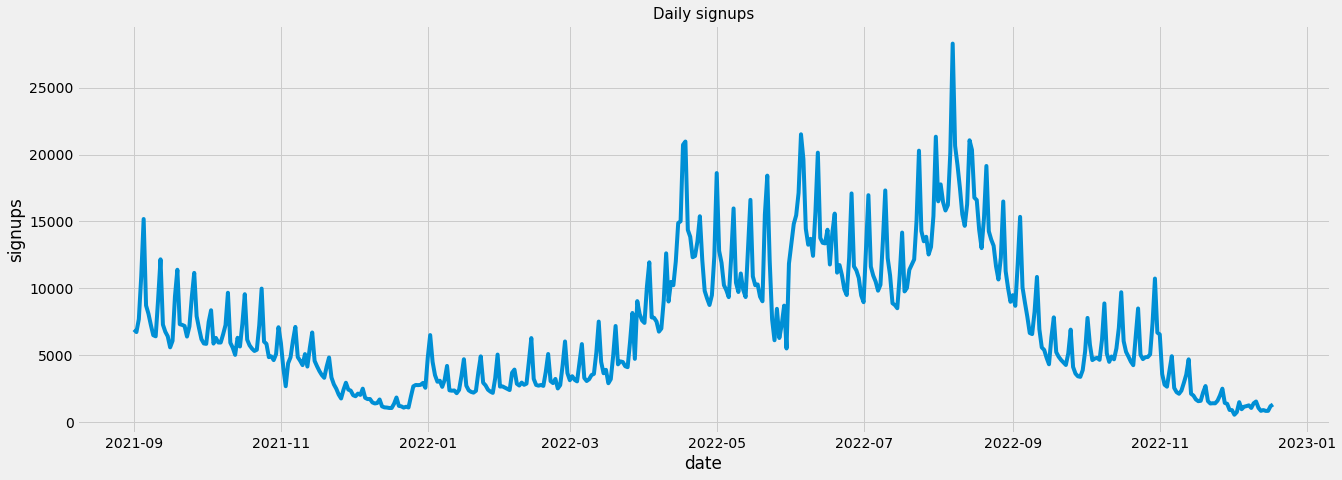

In [14]:
## Plot the Time series data
fig, ax = plt.subplots(figsize=(20,7))
a = sns.lineplot(x="date", y="signups", data=df)
a.set_title("Daily signups",fontsize=15)
plt.show()

In [15]:
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')

In [16]:
def date_features(df, label=None):
    df = df.copy()

    df['date'] = df.date
    df['month'] = df['date'].dt.strftime('%B')
    df['year'] = df['date'].dt.strftime('%Y')
    df['dayofweek'] = df['date'].dt.strftime('%A')
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X
X, y = date_features(df, label='signups')
df_new = pd.concat([X, y], axis=1)
df_new.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,signups
0,Wednesday,3,September,2021,244,1,35,6928
1,Thursday,3,September,2021,245,2,35,6745
2,Friday,3,September,2021,246,3,35,7708
3,Saturday,3,September,2021,247,4,35,10911
4,Sunday,3,September,2021,248,5,35,15185


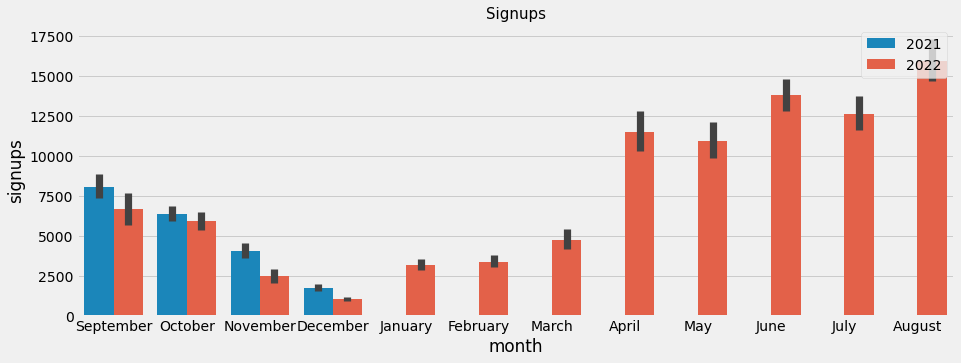

In [17]:
fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="month", y="signups",hue = 'year',data=df_new)
a.set_title("Signups",fontsize=15)
plt.legend(loc='upper right')
plt.show()

Text(0.5, 1.0, 'Total Signups received By year')

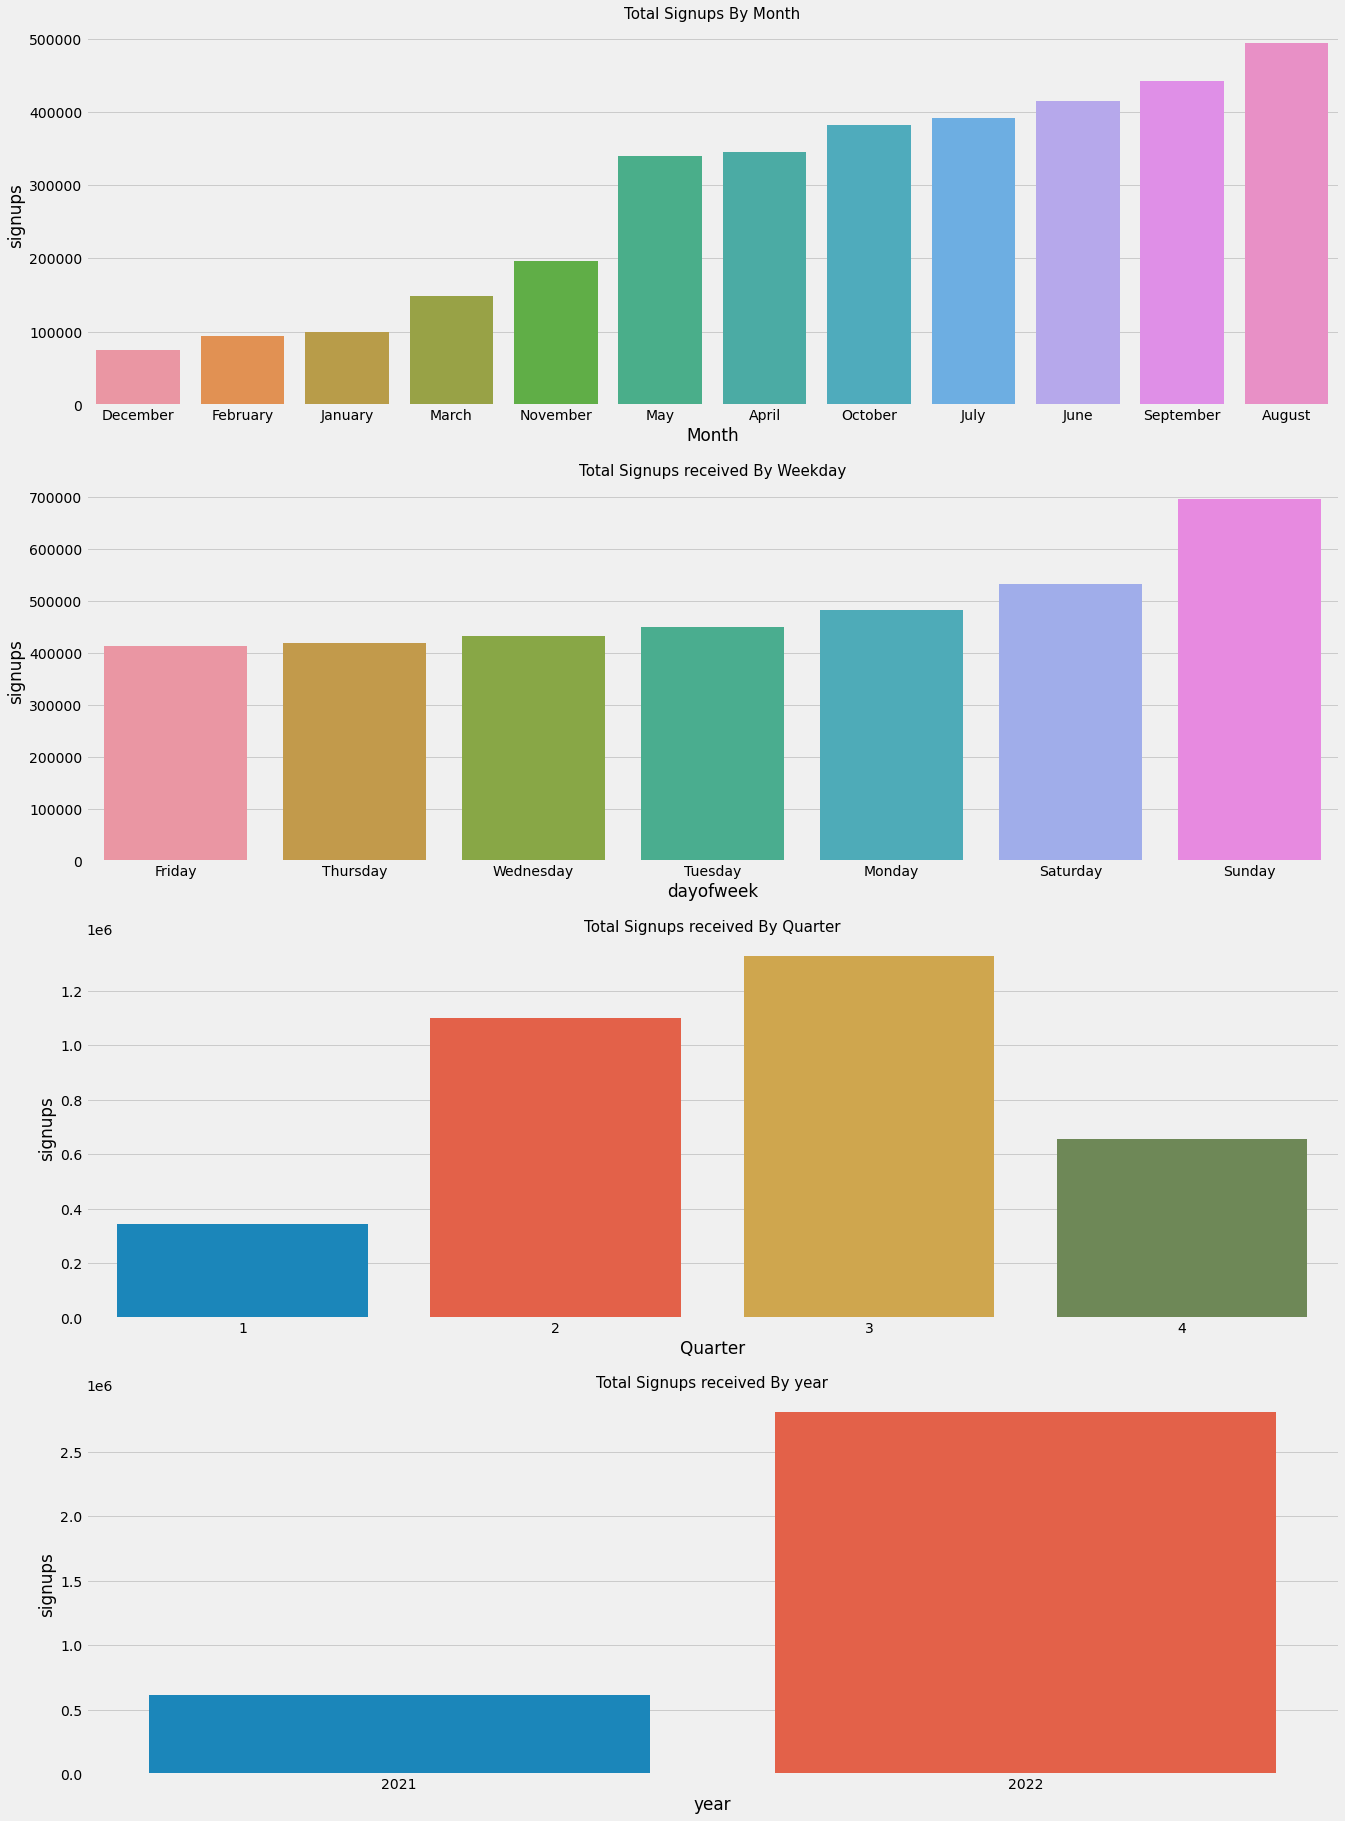

In [19]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(20,30)

monthAggregated = pd.DataFrame(df_new.groupby("month")["signups"].sum()).reset_index().sort_values('signups')
sns.barplot(data=monthAggregated,x="month",y="signups",ax=ax1)
ax1.set(xlabel='Month', ylabel='signups')
ax1.set_title("Total Signups By Month",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("dayofweek")["signups"].sum()).reset_index().sort_values('signups')
sns.barplot(data=monthAggregated,x="dayofweek",y="signups",ax=ax2)
ax2.set(xlabel='dayofweek', ylabel='signups')
ax2.set_title("Total Signups received By Weekday",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("quarter")["signups"].sum()).reset_index().sort_values('signups')
sns.barplot(data=monthAggregated,x="quarter",y="signups",ax=ax3)
ax3.set(xlabel='Quarter', ylabel='signups')
ax3.set_title("Total Signups received By Quarter",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("year")["signups"].sum()).reset_index().sort_values('year')
sns.barplot(data=monthAggregated,x="year",y="signups",ax=ax4)
ax4.set(xlabel='year', ylabel='signups')
ax4.set_title("Total Signups received By year",fontsize=15)

In [20]:
df=df.rename(columns={'date':'ds','signups':'y'})
df.head()

,ds,y
0,2021-09-01,6928
1,2021-09-02,6745
2,2021-09-03,7708
3,2021-09-04,10911
4,2021-09-05,15185


## Dividing the dataset into train and test. The training data is from September 2021 to October 2022. Test Data has 3 months from October 2022 to December 2022.

In [21]:
end_date = '2022-09-30'
mask1 = (df['ds'] <= end_date)
mask2 = (df['ds'] > end_date)

In [22]:
X_tr = df.loc[mask1]
X_tst = df.loc[mask2]
print("train shape",X_tr.shape)
print("test shape",X_tst.shape)

train shape (395, 2)
test shape (79, 2)


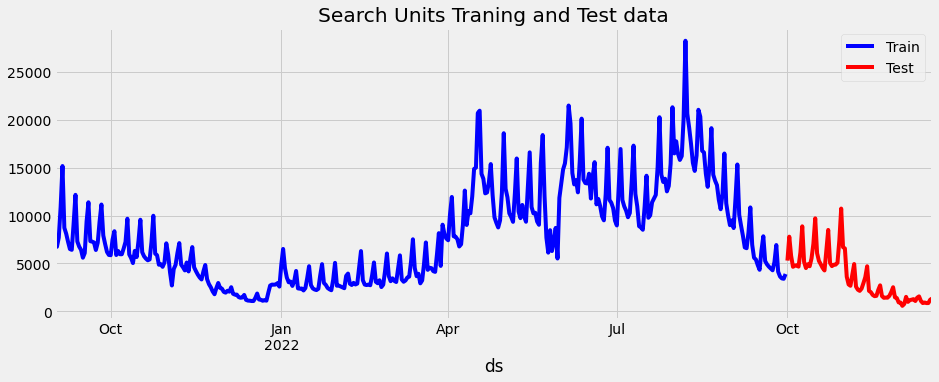

In [23]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
X_tr.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
X_tst.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title('Signups Actuals and Test data')
plt.show()

In [24]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [25]:
model =Prophet()
model.fit(X_tr)

15:29:33 - cmdstanpy - INFO - Chain [1] start processing
15:29:33 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
future = model.make_future_dataframe(periods=90, freq='D')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
478,2022-12-23,2498.742378,-1685.587393,6344.531489
479,2022-12-24,4401.441026,193.036446,8373.873842
480,2022-12-25,6930.753908,2820.261764,10732.036872
481,2022-12-26,3547.753422,-850.025698,7354.344920
482,2022-12-27,2952.151714,-1189.329953,6776.744049
483,2022-12-28,2529.241423,-1724.560051,6207.735299
484,2022-12-29,2234.225297,-1952.952143,6369.312540


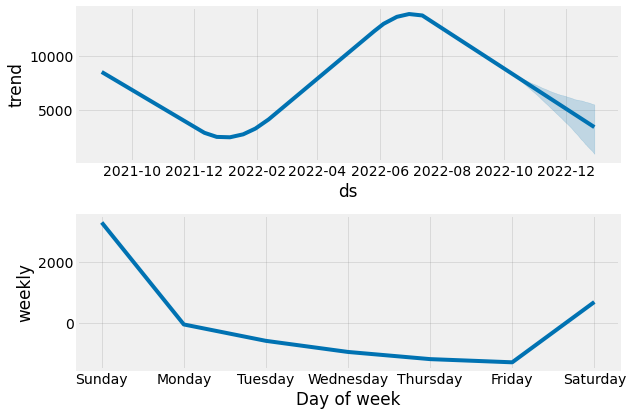

In [27]:
# Plot the components of the model
fig = model.plot_components(forecast)

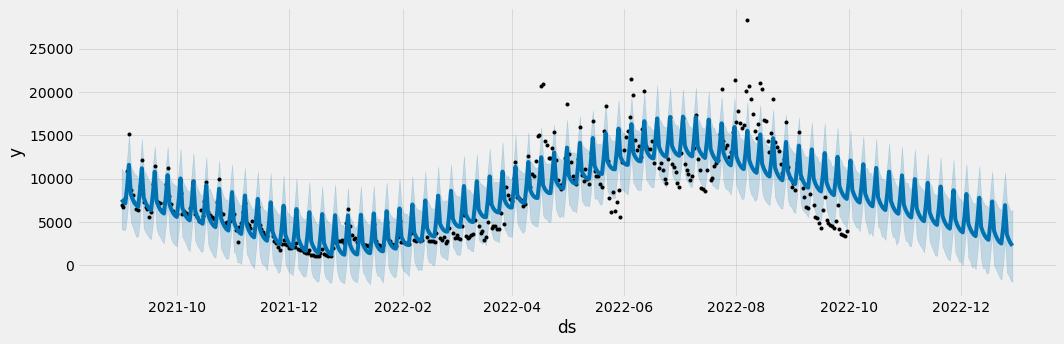

In [28]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.show()

In [29]:
X_tst_forecast = model.predict(X_tst)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
72,2022-12-12,4406.808867,706.875218,7838.373822
73,2022-12-13,3811.207159,76.697937,7690.647443
74,2022-12-14,3388.296868,-220.032679,7299.674339
75,2022-12-15,3093.280742,-680.748250,7070.553889
76,2022-12-16,2928.270100,-1027.358890,6606.396797
77,2022-12-17,4830.968748,735.831101,8840.791399
78,2022-12-18,7360.281630,3180.753467,11258.918079


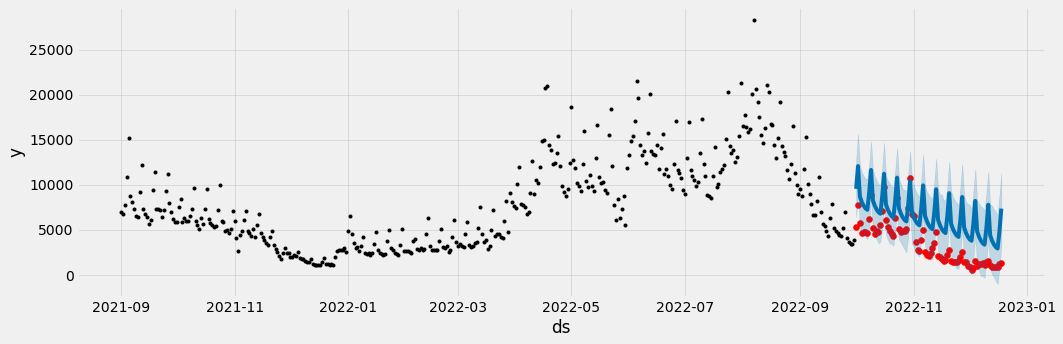

In [30]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(X_tst.ds, X_tst['y'], color='r')
fig = model.plot(X_tst_forecast, ax=ax)

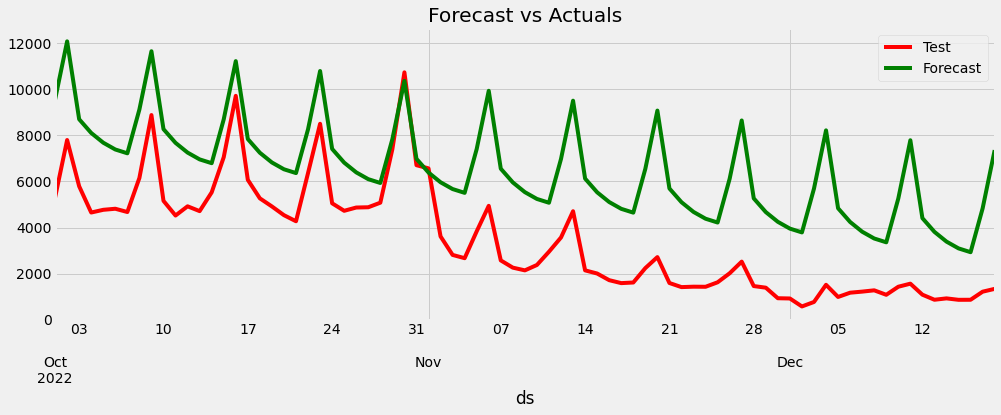

In [31]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
X_tst_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

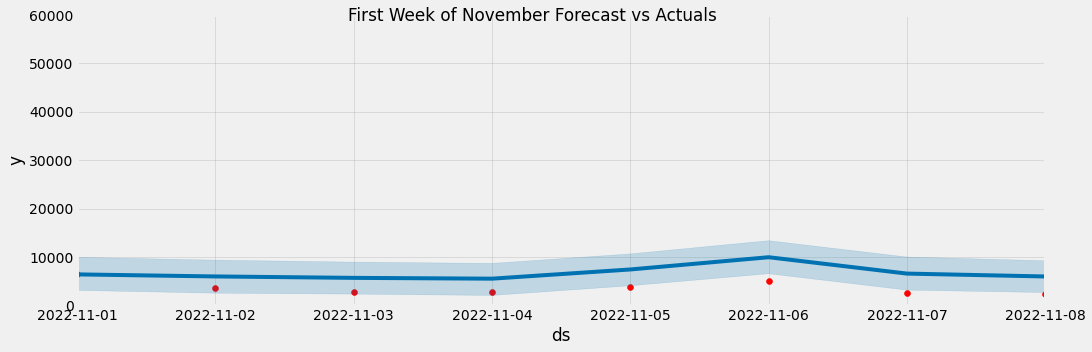

In [37]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(X_tst.ds, X_tst['y'], color='r')
fig = model.plot(X_tst_forecast, ax=ax)
ax.set_xlim([pd.to_datetime('2022-11-01', format = '%Y-%m-%d'),
             pd.to_datetime('2022-11-08', format = '%Y-%m-%d')])
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of November Forecast vs Actuals')

In [38]:
mape = mean_absolute_percentage_error(X_tst['y'],X_tst_forecast['yhat'])
print("MAPE",round(mape,4))

MAPE 157.353


In [39]:
import holidays

In [40]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedKingdom(years=[2020,2021,2022]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "UK-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [41]:
holiday.head()

,ds,holiday
0,2020-01-01,UK-Holidays
1,2020-01-02,UK-Holidays
2,2020-03-17,UK-Holidays
3,2020-04-10,UK-Holidays
4,2020-04-13,UK-Holidays


In [42]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(X_tr)

15:50:21 - cmdstanpy - INFO - Chain [1] start processing
15:50:21 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
future = model_with_holidays.make_future_dataframe(periods=90, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
478,2022-12-23,2528.405684,-1413.127283,6700.392835
479,2022-12-24,4431.910823,118.573908,8352.683570
480,2022-12-25,8475.882438,4664.156026,12564.318178
481,2022-12-26,4957.246255,883.444218,8962.894893
482,2022-12-27,4443.478142,287.709630,8525.495564
483,2022-12-28,2615.674089,-1213.802731,6691.204199
484,2022-12-29,2268.108466,-1748.138797,6454.580816


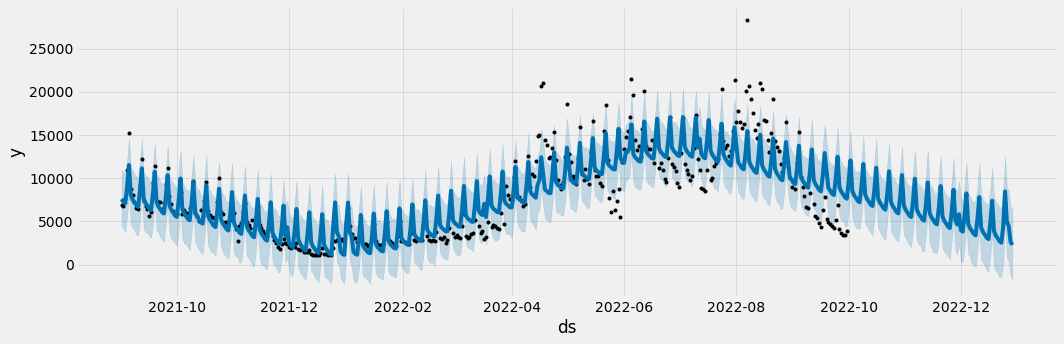

In [56]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

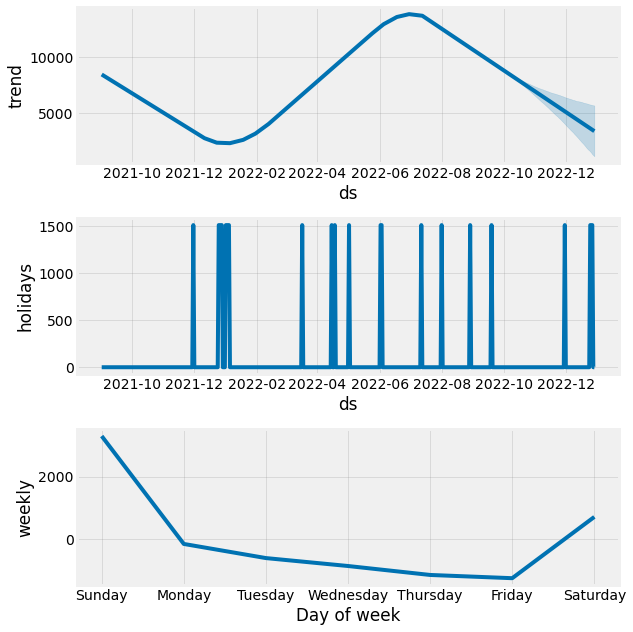

In [57]:
fig = model_with_holidays.plot_components(forecast)

In [58]:
X_tst_forecast_holiday = model_with_holidays.predict(X_tst)
X_tst_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
72,2022-12-12,4293.617067,624.170655,8281.713035
73,2022-12-13,3779.848954,97.787953,7536.111461
74,2022-12-14,3465.013588,-78.270574,7219.982362
75,2022-12-15,3117.447966,-800.246878,6818.284882
76,2022-12-16,2953.075434,-968.625668,6807.527142
77,2022-12-17,4856.580573,1072.225106,8750.860574
78,2022-12-18,7387.583500,3516.635745,11364.672573


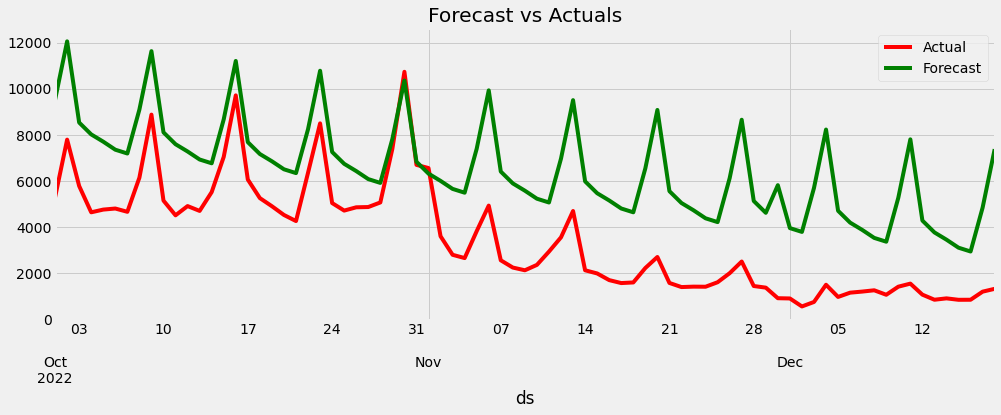

In [59]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

In [60]:
mape = mean_absolute_percentage_error(X_tst['y'],X_tst_forecast_holiday['yhat'])
print("MAPE",round(mape,4))

MAPE 159.041


In [61]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [63]:
strt='2022-06-01'
end='2022-12-15'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='UK')
    train_model.fit(X_tr)
    train_forecast = train_model.make_future_dataframe(periods=197, freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = df[(df['ds']>strt) & (df['ds']<=end)]
    MAPE = mean_absolute_percentage_error(Actual['y'],abs(test['yhat']))
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

16:02:38 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:02:38 - cmdstanpy - INFO - Chain [1] done processing
16:02:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 188.72314380830085
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:02:39 - cmdstanpy - INFO - Chain [1] done processing
16:02:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 133.40585678129463
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:02:39 - cmdstanpy - INFO - Chain [1] done processing
16:02:40 - cmdstanpy - INFO - Chain [1] start processing
16:02:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 199.60055264309287
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:02:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 133.1763036078602
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:02:40 - cmdstanpy - INFO - Chain [1] done processing
16:02:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 199.69603690976285
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:02:41 - cmdstanpy - INFO - Chain [1] done processing
16:02:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 133.35372633370284
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:02:42 - cmdstanpy - INFO - Chain [1] done processing
16:02:42 - cmdstanpy - INFO - Chain [1] start processing
16:02:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 200.29294621961066
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:02:42 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 133.97263446836052
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:02:43 - cmdstanpy - INFO - Chain [1] done processing
16:02:43 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 200.9096491698172
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:02:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 133.84690683265163
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:02:43 - cmdstanpy - INFO - Chain [1] start processing
16:02:44 - cmdstanpy - INFO - Chain [1] done processing
16:02:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 199.243899310242
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:02:44 - cmdstanpy - INFO - Chain [1] done processing
16:02:45 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 133.8980075386756
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:02:45 - cmdstanpy - INFO - Chain [1] done processing
16:02:45 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 200.12082162808832
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:02:45 - cmdstanpy - INFO - Chain [1] done processing
16:02:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 134.00069430509097
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:02:46 - cmdstanpy - INFO - Chain [1] done processing
16:02:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 207.1286843767445
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:02:47 - cmdstanpy - INFO - Chain [1] done processing
16:02:47 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 133.99263043920845
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:02:47 - cmdstanpy - INFO - Chain [1] done processing
16:02:48 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 198.99985996786384
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:02:48 - cmdstanpy - INFO - Chain [1] done processing
16:02:48 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 134.01878543988585
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:02:49 - cmdstanpy - INFO - Chain [1] done processing
16:02:49 - cmdstanpy - INFO - Chain [1] start processing
16:02:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 201.17439460143464
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:02:49 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 134.06946802715538
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:02:49 - cmdstanpy - INFO - Chain [1] done processing
16:02:50 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 214.00936645993843
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:02:50 - cmdstanpy - INFO - Chain [1] done processing
16:02:50 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 134.077413242385
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:02:51 - cmdstanpy - INFO - Chain [1] done processing
16:02:51 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 208.47199507444674
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:02:51 - cmdstanpy - INFO - Chain [1] done processing
16:02:51 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 133.91063478855693
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:02:52 - cmdstanpy - INFO - Chain [1] done processing
16:02:52 - cmdstanpy - INFO - Chain [1] start processing
16:02:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 215.48207758528025
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:02:52 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 133.95636696014745
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:02:53 - cmdstanpy - INFO - Chain [1] done processing
16:02:53 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 224.16595560971925
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:02:53 - cmdstanpy - INFO - Chain [1] done processing
16:02:54 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 134.07799297354504
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:02:54 - cmdstanpy - INFO - Chain [1] done processing
16:02:54 - cmdstanpy - INFO - Chain [1] start processing
16:02:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 222.68062880035612
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:02:55 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 133.9382144479604
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:02:55 - cmdstanpy - INFO - Chain [1] done processing
16:02:56 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 210.41062284424137
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:02:56 - cmdstanpy - INFO - Chain [1] done processing
16:02:56 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 126.7408181249563
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:02:57 - cmdstanpy - INFO - Chain [1] done processing
16:02:57 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 205.68835372066565
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:02:57 - cmdstanpy - INFO - Chain [1] done processing
16:02:57 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 91.12407992216087
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:02:58 - cmdstanpy - INFO - Chain [1] done processing
16:02:58 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 211.10992062314264
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:02:59 - cmdstanpy - INFO - Chain [1] done processing
16:02:59 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 130.66744361800798
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:02:59 - cmdstanpy - INFO - Chain [1] done processing
16:02:59 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 206.86666207238824
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:03:00 - cmdstanpy - INFO - Chain [1] done processing
16:03:00 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 129.16843515290975
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:03:00 - cmdstanpy - INFO - Chain [1] done processing
16:03:01 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 202.22067642839167
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:03:01 - cmdstanpy - INFO - Chain [1] done processing
16:03:01 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 126.74970489799999
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:03:02 - cmdstanpy - INFO - Chain [1] done processing
16:03:02 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 204.98438883101767
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:03:02 - cmdstanpy - INFO - Chain [1] done processing
16:03:02 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 111.83718791304524
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:03:03 - cmdstanpy - INFO - Chain [1] done processing
16:03:03 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 209.34524591044928
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:03:03 - cmdstanpy - INFO - Chain [1] done processing
16:03:04 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 115.29059806117141
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:03:04 - cmdstanpy - INFO - Chain [1] done processing
16:03:04 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 209.27351873803036
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:03:04 - cmdstanpy - INFO - Chain [1] done processing
16:03:05 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 129.32145871218736
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:03:05 - cmdstanpy - INFO - Chain [1] done processing
16:03:05 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 210.06552270339597
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:03:06 - cmdstanpy - INFO - Chain [1] done processing
16:03:06 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 132.91684449689387
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:03:06 - cmdstanpy - INFO - Chain [1] done processing
16:03:07 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 217.34746068660513
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:03:07 - cmdstanpy - INFO - Chain [1] done processing
16:03:07 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 127.7328835556668
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:03:07 - cmdstanpy - INFO - Chain [1] done processing
16:03:08 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 212.42636202061703
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:03:08 - cmdstanpy - INFO - Chain [1] done processing
16:03:08 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 110.01443678531373
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:03:09 - cmdstanpy - INFO - Chain [1] done processing
16:03:09 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 212.96496007700037
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:03:09 - cmdstanpy - INFO - Chain [1] done processing
16:03:09 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 118.79664880039415
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:03:10 - cmdstanpy - INFO - Chain [1] done processing
16:03:10 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 218.02963369177618
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:03:10 - cmdstanpy - INFO - Chain [1] done processing
16:03:11 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 127.3808831604807
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:03:11 - cmdstanpy - INFO - Chain [1] done processing
16:03:11 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 214.61706145168117
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:03:11 - cmdstanpy - INFO - Chain [1] done processing
16:03:12 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 95.89537081192485
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:03:12 - cmdstanpy - INFO - Chain [1] done processing
16:03:12 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 215.32803349735053
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:03:13 - cmdstanpy - INFO - Chain [1] done processing
16:03:13 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 124.89431966710795
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:03:13 - cmdstanpy - INFO - Chain [1] done processing
16:03:14 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 202.2846831215845
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:03:14 - cmdstanpy - INFO - Chain [1] done processing
16:03:14 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 197.81883141620696
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:03:14 - cmdstanpy - INFO - Chain [1] done processing
16:03:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 199.71755673917633
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:03:15 - cmdstanpy - INFO - Chain [1] done processing
16:03:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 186.23075244551686
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:03:16 - cmdstanpy - INFO - Chain [1] done processing
16:03:16 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 199.3409236741924
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:03:16 - cmdstanpy - INFO - Chain [1] done processing
16:03:16 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 180.32949585397776
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:03:17 - cmdstanpy - INFO - Chain [1] done processing
16:03:17 - cmdstanpy - INFO - Chain [1] start processing
16:03:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 200.47049121622265
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:03:17 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 208.6165608230902
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:03:18 - cmdstanpy - INFO - Chain [1] done processing
16:03:18 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 198.4395164847397
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:03:18 - cmdstanpy - INFO - Chain [1] done processing
16:03:18 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 179.25756957942244
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:03:19 - cmdstanpy - INFO - Chain [1] done processing
16:03:19 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 201.8212479841412
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:03:19 - cmdstanpy - INFO - Chain [1] done processing
16:03:20 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 210.134127303786
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:03:21 - cmdstanpy - INFO - Chain [1] done processing
16:03:22 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 277.13702627325586
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:03:22 - cmdstanpy - INFO - Chain [1] done processing
16:03:22 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 222.19527571158636
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:03:23 - cmdstanpy - INFO - Chain [1] done processing
16:03:23 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 208.42868316933846
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:03:23 - cmdstanpy - INFO - Chain [1] done processing
16:03:24 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 211.83003920400273
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:03:24 - cmdstanpy - INFO - Chain [1] done processing
16:03:24 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 206.48786451811287
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:03:25 - cmdstanpy - INFO - Chain [1] done processing
16:03:25 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 198.10317143872817
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:03:26 - cmdstanpy - INFO - Chain [1] done processing
16:03:26 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 282.6137425138701
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:03:26 - cmdstanpy - INFO - Chain [1] done processing
16:03:27 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 206.9272562185174
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:03:28 - cmdstanpy - INFO - Chain [1] done processing
16:03:29 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 287.41608485839197
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:03:29 - cmdstanpy - INFO - Chain [1] done processing
16:03:29 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 191.6886365863761
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:03:31 - cmdstanpy - INFO - Chain [1] done processing
16:03:31 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 282.58783917553217
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:03:31 - cmdstanpy - INFO - Chain [1] done processing
16:03:32 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 204.47135795863272
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:03:33 - cmdstanpy - INFO - Chain [1] done processing
16:03:34 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 280.2645751810801
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:03:34 - cmdstanpy - INFO - Chain [1] done processing
16:03:34 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 220.77087057346012
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:03:36 - cmdstanpy - INFO - Chain [1] done processing
16:03:36 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 277.3101918919656
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:03:36 - cmdstanpy - INFO - Chain [1] done processing
16:03:36 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 212.85076853381045
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:03:38 - cmdstanpy - INFO - Chain [1] done processing
16:03:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 290.42717452149924
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:03:39 - cmdstanpy - INFO - Chain [1] done processing
16:03:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 207.26590504350705
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:03:39 - cmdstanpy - INFO - Chain [1] done processing
16:03:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 197.0721212862914
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:03:40 - cmdstanpy - INFO - Chain [1] done processing
16:03:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 260.16107908158557
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:03:40 - cmdstanpy - INFO - Chain [1] done processing
16:03:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 199.37444614861758
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:03:41 - cmdstanpy - INFO - Chain [1] done processing
16:03:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 282.0908796878471
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:03:42 - cmdstanpy - INFO - Chain [1] done processing
16:03:42 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 198.0425241290368
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:03:42 - cmdstanpy - INFO - Chain [1] done processing
16:03:42 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 258.12740057450463
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:03:43 - cmdstanpy - INFO - Chain [1] done processing
16:03:43 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 202.56623313821515
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:03:44 - cmdstanpy - INFO - Chain [1] done processing
16:03:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 300.2090710555654
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:03:45 - cmdstanpy - INFO - Chain [1] done processing
16:03:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 299.1396243397756
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:03:46 - cmdstanpy - INFO - Chain [1] done processing
16:03:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 262.37786725770235
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:03:47 - cmdstanpy - INFO - Chain [1] done processing
16:03:47 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 201.5381018160158
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:03:47 - cmdstanpy - INFO - Chain [1] done processing
16:03:47 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 262.8264015879377
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:03:49 - cmdstanpy - INFO - Chain [1] done processing
16:03:49 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 284.15066307601245
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:03:49 - cmdstanpy - INFO - Chain [1] done processing
16:03:50 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 316.1726701167489
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:03:51 - cmdstanpy - INFO - Chain [1] done processing
16:03:52 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 296.39399860115725
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:03:52 - cmdstanpy - INFO - Chain [1] done processing
16:03:52 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 270.1768967187305
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:03:54 - cmdstanpy - INFO - Chain [1] done processing
16:03:54 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 279.35522721899815
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:03:55 - cmdstanpy - INFO - Chain [1] done processing
16:03:55 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 268.43368151868964
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:03:56 - cmdstanpy - INFO - Chain [1] done processing
16:03:56 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 279.57028503599105
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:03:57 - cmdstanpy - INFO - Chain [1] done processing
16:03:57 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 257.7426529013312
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:03:59 - cmdstanpy - INFO - Chain [1] done processing
16:03:59 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 284.3347864034762
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:03:59 - cmdstanpy - INFO - Chain [1] done processing
16:03:59 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 274.6340115626402
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:04:01 - cmdstanpy - INFO - Chain [1] done processing
16:04:02 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 283.22221939256553
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:04:02 - cmdstanpy - INFO - Chain [1] done processing
16:04:02 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 267.59978165437815
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:04:03 - cmdstanpy - INFO - Chain [1] done processing
16:04:04 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 278.99529348200485
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:04:04 - cmdstanpy - INFO - Chain [1] done processing
16:04:04 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 289.8540956329532
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:04:06 - cmdstanpy - INFO - Chain [1] done processing
16:04:06 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 291.4088228138986
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:04:06 - cmdstanpy - INFO - Chain [1] done processing
16:04:07 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 296.13079146345285
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:04:08 - cmdstanpy - INFO - Chain [1] done processing
16:04:09 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 285.12653293996107
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:04:09 - cmdstanpy - INFO - Chain [1] done processing
16:04:09 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 275.83872542736344
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:04:09 - cmdstanpy - INFO - Chain [1] done processing
16:04:10 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 194.65446775101367
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:04:10 - cmdstanpy - INFO - Chain [1] done processing
16:04:10 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 305.95613517589067
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:04:12 - cmdstanpy - INFO - Chain [1] done processing
16:04:12 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 302.23706275699993
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:04:12 - cmdstanpy - INFO - Chain [1] done processing
16:04:13 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 306.78017119264047
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:04:13 - cmdstanpy - INFO - Chain [1] done processing
16:04:13 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 196.0634550554747
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:04:13 - cmdstanpy - INFO - Chain [1] done processing
16:04:14 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 307.130652530651
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:04:15 - cmdstanpy - INFO - Chain [1] done processing
16:04:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 280.3017447958072
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:04:16 - cmdstanpy - INFO - Chain [1] done processing
16:04:16 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 300.49520080697613
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:04:17 - cmdstanpy - INFO - Chain [1] done processing
16:04:18 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 300.5517927383396
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:04:18 - cmdstanpy - INFO - Chain [1] done processing
16:04:18 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 324.9130073942188
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:04:20 - cmdstanpy - INFO - Chain [1] done processing
16:04:20 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 294.1263309924332
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:04:20 - cmdstanpy - INFO - Chain [1] done processing
16:04:21 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 315.8825095045914
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:04:22 - cmdstanpy - INFO - Chain [1] done processing
16:04:22 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 288.66951009558113
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:04:23 - cmdstanpy - INFO - Chain [1] done processing
16:04:23 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 309.5876582029652
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:04:25 - cmdstanpy - INFO - Chain [1] done processing
16:04:25 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 300.17708089965225
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:04:25 - cmdstanpy - INFO - Chain [1] done processing
16:04:25 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 299.66488681759415
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:04:27 - cmdstanpy - INFO - Chain [1] done processing
16:04:28 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 293.6622766392767
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:04:28 - cmdstanpy - INFO - Chain [1] done processing
16:04:28 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 315.37479761288444
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:04:30 - cmdstanpy - INFO - Chain [1] done processing
16:04:30 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 279.8804098956279
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:04:30 - cmdstanpy - INFO - Chain [1] done processing
16:04:30 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 317.8416403546878
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:04:32 - cmdstanpy - INFO - Chain [1] done processing
16:04:32 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 291.4918468165233
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:04:32 - cmdstanpy - INFO - Chain [1] done processing
16:04:33 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 299.4023448990979
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:04:35 - cmdstanpy - INFO - Chain [1] done processing
16:04:35 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 292.8021951725776
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:04:35 - cmdstanpy - INFO - Chain [1] done processing
16:04:35 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 304.37044120251164
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


16:04:36 - cmdstanpy - INFO - Chain [1] done processing
16:04:37 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 281.8700957088606
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


16:04:37 - cmdstanpy - INFO - Chain [1] done processing
16:04:37 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 307.54462222110084
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


16:04:39 - cmdstanpy - INFO - Chain [1] done processing
16:04:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 290.9288145747227
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


16:04:39 - cmdstanpy - INFO - Chain [1] done processing
16:04:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 302.40455187068414
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


16:04:41 - cmdstanpy - INFO - Chain [1] done processing
16:04:42 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 289.18161087658376
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


16:04:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 300.47218121581494


In [64]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,91.12408,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."
1,95.895371,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."
2,110.014437,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."
3,111.837188,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."
4,115.290598,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."


In [ ]:
# Out of total 150 models, we will select the parameters which has the least MAPE to train the final model and predict the next 2 months sales of the store.

## Best Parameters on which the model has the least MAPE is:

In [65]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.2,
 'holidays_prior_scale': 0.1,
 'n_changepoints': 150,
 'seasonality_mode': 'additive'}

In [66]:
# Setup and train model with holidays
final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.2,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 150,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
#final_model.add_country_holidays(country_name='US')
final_model.fit(X_tr)

16:07:16 - cmdstanpy - INFO - Chain [1] start processing
16:07:17 - cmdstanpy - INFO - Chain [1] done processing


In [69]:
future = final_model.make_future_dataframe(periods=180, freq='D')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
568,2023-03-23,-7251.020579,-10345.408498,-4399.696414
569,2023-03-24,-7197.450915,-10164.408868,-4168.786968
570,2023-03-25,-5132.714222,-8268.521998,-2116.099286
571,2023-03-26,-2347.783329,-5345.549664,536.377783
572,2023-03-27,-5558.837910,-8472.907280,-2566.395930
573,2023-03-28,-5799.210272,-8875.029829,-2776.706586
574,2023-03-29,-5867.293297,-8848.325318,-2837.415056


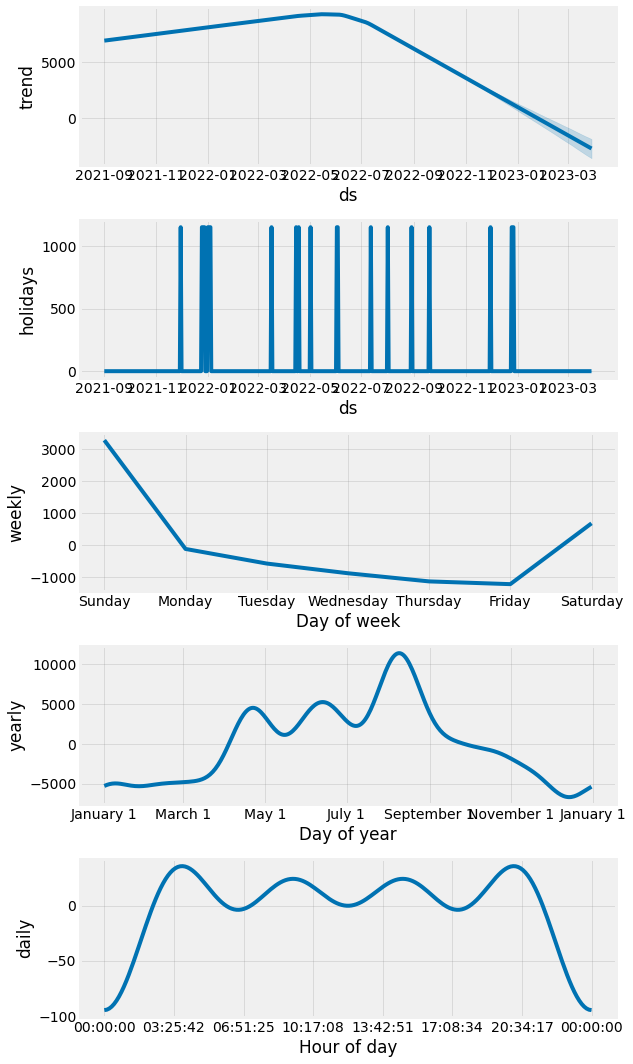

In [70]:
# Plot the components of the model
fig = final_model.plot_components(forecast)

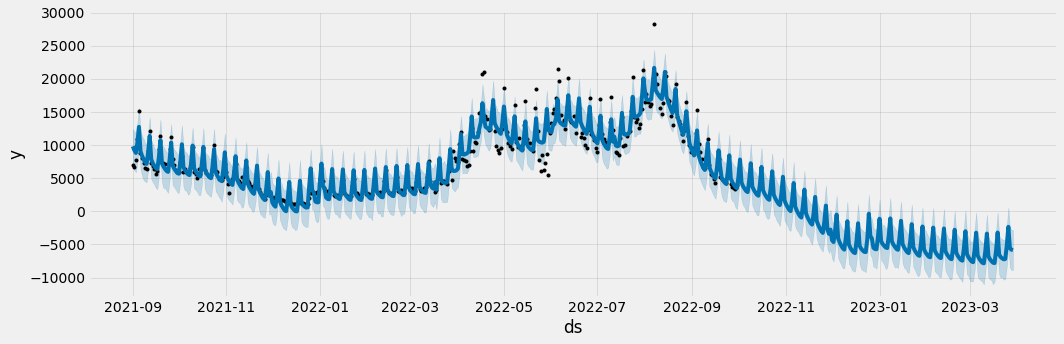

In [71]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model.plot(forecast,ax=ax)
plt.show()

In [72]:
X_tst_final= final_model.predict(X_tst)
X_tst_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
72,2022-12-12,-5003.110741,-7972.647526,-1945.808939
73,2022-12-13,-5535.295945,-8412.927818,-2540.742784
74,2022-12-14,-5898.728902,-9003.651908,-2835.426359
75,2022-12-15,-6198.007572,-9090.027893,-3332.654490
76,2022-12-16,-6312.514781,-9300.691635,-3480.660518
77,2022-12-17,-4420.305217,-7277.922536,-1663.561843
78,2022-12-18,-1813.483352,-4705.014127,1027.887584


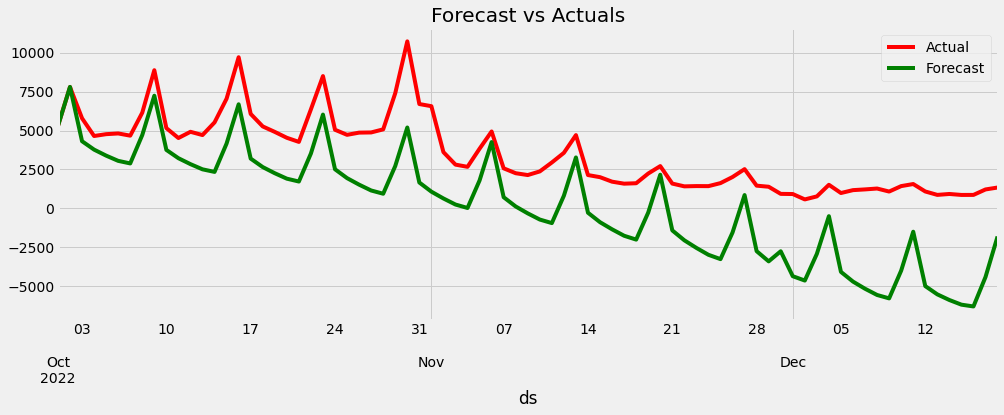

In [73]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

In [74]:
MAPE = mean_absolute_percentage_error(X_tst['y'],abs(X_tst_final['yhat']))
print('MAPE', MAPE)

MAPE 123.62364070832467
